In [2]:
# imports

import sqlite3
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [4]:
# filter out warnings

warnings.filterwarnings('ignore')

In [3]:
# display settings (pandas)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

In [6]:
class NBAFeatureEngineer:
    def __init__(self, db_path='../data/raw/nba.sqlite'):
        self.db_path = db_path
        self.conn = None
        self.top_players = None
        self.player_data = None
        
    def connect(self):
        """Connect to database"""
        self.conn = sqlite3.connect(self.db_path)
        print(f"Connected to {self.db_path}")


In [7]:
# Intializes and connects

engineer = NBAFeatureEngineer()
engineer.connect()

Connected to ../data/raw/nba.sqlite


In [27]:
def load_top_players_from_eda(self):
    """
    Loads the top 20 players identified in EDA with 100+ games
    Based on analyze_2015_plus_suitability() findings
    """
    query = """
    SELECT
        pbp.player1_id,
        pbp.player1_name,
        COUNT(DISTINCT pbp.game_id) as games_played,
        COUNT(*) as total_actions,
        MIN(g.game_date) as first_game,
        MAX(g.game_date) as last_game,
        COUNT(DISTINCT SUBSTR(g.game_date, 1, 4)) as seasons_active
    FROM play_by_play pbp
    JOIN game g ON pbp.game_id = g.game_id
    WHERE g.game_date >= '2015-01-01'
    AND pbp.player1_id IS NOT NULL
    AND pbp.player1_id != '0'
    GROUP BY pbp.player1_id, pbp.player1_name
    HAVING COUNT(DISTINCT pbp.game_id) >= 100
    ORDER BY total_actions DESC
    LIMIT 20
    """
    
    self.top_players = pd.read_sql_query(query, self.conn)
    print(f"Loaded {len(self.top_players)} top players for modeling")
    return self.top_players

# Monkey patching method to class
NBAFeatureEngineer.load_top_players_from_eda = load_top_players_from_eda

In [28]:
# Loads top players from EDA analysis
top_players = engineer.load_top_players_from_eda()

# Display results
print(f"\nTop Players for Injury Prediction Modeling:")
display(top_players[['player1_name', 'games_played', 'total_actions', 'seasons_active']])

# Stores player names for reference
player_names = top_players['player1_name'].tolist()
print(f"\nPlayers selected: {', '.join(player_names[:5])}... (and {len(player_names)-5} more)")

Loaded 20 top players for modeling

Top Players for Injury Prediction Modeling:


,player1_name,games_played,total_actions,seasons_active
0,Giannis Antetokounmpo,661,30862,9
1,James Harden,672,29814,9
2,Russell Westbrook,643,29320,9
3,LeBron James,633,27857,9
4,Nikola Jokic,629,24239,9
5,DeMar DeRozan,644,23455,9
6,Anthony Davis,530,23407,9
7,Stephen Curry,610,22779,9
8,Damian Lillard,596,22426,9
9,Julius Randle,596,22244,9



Players selected: Giannis Antetokounmpo, James Harden, Russell Westbrook, LeBron James, Nikola Jokic... (and 15 more)


In [10]:
def load_player_game_data(self, start_date='2015-01-01', end_date='2023-06-12'):
    """
    Loads playergame level data for top players
    Based on EDA event type distributions and clean data filtering
    """
    # Gets player IDs for filtering
    if self.top_players is None:
        self.load_top_players_from_eda()
    
    player_ids = "', '".join(self.top_players['player1_id'].astype(str))
    
    query = f"""
    SELECT
        pbp.game_id,
        g.game_date,
        pbp.player1_id as player_id,
        pbp.player1_name as player_name,
        g.season_id,
        g.season_type,
        
        -- Total activity metrics
        COUNT(*) as total_actions,
        
        -- Event type breakdowns (based on EDA findings)
        -- Shooting Load (Types 1+2+3 = 37.4% of actions)
        SUM(CASE WHEN pbp.eventmsgtype = 1 THEN 1 ELSE 0 END) as made_shots,
        SUM(CASE WHEN pbp.eventmsgtype = 2 THEN 1 ELSE 0 END) as missed_shots,  
        SUM(CASE WHEN pbp.eventmsgtype = 3 THEN 1 ELSE 0 END) as free_throws,
        
        -- Defensive Load (Type 4 = 22.5% of actions)
        SUM(CASE WHEN pbp.eventmsgtype = 4 THEN 1 ELSE 0 END) as rebounds,
        
        -- Physical Contact Load (Types 6+3 = 18.7%)
        SUM(CASE WHEN pbp.eventmsgtype = 6 THEN 1 ELSE 0 END) as fouls,
        
        -- Ball Handling Stress (Type 5 = 6.1%)
        SUM(CASE WHEN pbp.eventmsgtype = 5 THEN 1 ELSE 0 END) as turnovers,
        
        -- Substitution tracking (Type 8 = 9.8%)
        SUM(CASE WHEN pbp.eventmsgtype = 8 THEN 1 ELSE 0 END) as substitutions,
        
        -- Other events
        SUM(CASE WHEN pbp.eventmsgtype NOT IN (1,2,3,4,5,6,8) THEN 1 ELSE 0 END) as other_events
        
    FROM play_by_play pbp
    JOIN game g ON pbp.game_id = g.game_id
    WHERE g.game_date >= '{start_date}'
    AND g.game_date <= '{end_date}'
    AND pbp.player1_id IN ('{player_ids}')
    AND pbp.player1_id IS NOT NULL
    AND pbp.player1_id != '0'
    AND g.season_type = 'Regular Season'  -- Focus on regular season for consistency
    GROUP BY pbp.game_id, pbp.player1_id, pbp.player1_name, g.game_date, g.season_id, g.season_type
    ORDER BY pbp.player1_id, g.game_date
    """
    
    # Loads data
    self.player_data = pd.read_sql_query(query, self.conn)
    
    # Convert game_date to datetime
    self.player_data['game_date'] = pd.to_datetime(self.player_data['game_date'])
    
    # Adds derived shooting metrics
    self.player_data['total_shot_attempts'] = (
        self.player_data['made_shots'] + self.player_data['missed_shots']
    )
    self.player_data['shooting_efficiency'] = (
        self.player_data['made_shots'] / 
        self.player_data['total_shot_attempts'].replace(0, np.nan)
    )
    
    return self.player_data

# Monkey patching method to class
NBAFeatureEngineer.load_player_game_data = load_player_game_data

In [11]:
# Loads player-game data
print("Loading player-game data based on EDA event type analysis...")

player_data = engineer.load_player_game_data()

print(f"Successfully loaded {len(player_data):,} player-game records")

Loading player-game data based on EDA event type analysis...
Successfully loaded 10,151 player-game records


In [12]:
# Displays loading summary
print("Play-Game Loading Summary")
print(f"- Total records: {len(player_data):,}")
print(f"- Unique players: {player_data['player_id'].nunique()}")
print(f"- Unique games: {player_data['game_id'].nunique()}")
print(f"- Date range: {player_data['game_date'].min().date()} to {player_data['game_date'].max().date()}")
print(f"- Seasons covered: {player_data['season_id'].nunique()}")

# Validates against EDA findings
print(f"\nEvent Type Validation (vs EDA findings):")
total_events = player_data[['made_shots', 'missed_shots', 'free_throws', 'rebounds', 'fouls', 'turnovers', 'substitutions']].sum().sum()
print(f"- Rebounds: {player_data['rebounds'].sum():,} ({player_data['rebounds'].sum()/total_events*100:.1f}% - EDA: 22.5%)")
print(f"- Missed shots: {player_data['missed_shots'].sum():,} ({player_data['missed_shots'].sum()/total_events*100:.1f}% - EDA: 20.2%)")
print(f"- Made shots: {player_data['made_shots'].sum():,} ({player_data['made_shots'].sum()/total_events*100:.1f}% - EDA: 17.2%)")

# Sample of data structure
print(f"\nSample Data Structure:")
display(player_data.head())

Play-Game Loading Summary
- Total records: 10,151
- Unique players: 20
- Unique games: 6592
- Date range: 2015-01-01 to 2023-04-09
- Seasons covered: 9

Event Type Validation (vs EDA findings):
- Rebounds: 84,065 (21.3% - EDA: 22.5%)
- Missed shots: 85,913 (21.8% - EDA: 20.2%)
- Made shots: 82,672 (21.0% - EDA: 17.2%)

Sample Data Structure:


,game_id,game_date,player_id,player_name,season_id,season_type,total_actions,made_shots,missed_shots,free_throws,rebounds,fouls,turnovers,substitutions,other_events,total_shot_attempts,shooting_efficiency
0,0021500029,2015-10-30,1626157,Karl-Anthony Towns,22015,Regular Season,47,11,8,7,14,3,1,3,0,19,0.578947
1,0021500050,2015-11-02,1626157,Karl-Anthony Towns,22015,Regular Season,30,5,4,0,5,5,4,3,4,9,0.555556
2,0021500071,2015-11-05,1626157,Karl-Anthony Towns,22015,Regular Season,25,3,10,0,4,3,0,3,2,13,0.230769
3,0021500085,2015-11-07,1626157,Karl-Anthony Towns,22015,Regular Season,40,8,10,1,13,4,0,4,0,18,0.444444
4,0021500101,2015-11-09,1626157,Karl-Anthony Towns,22015,Regular Season,34,5,2,8,12,3,2,2,0,7,0.714286


In [13]:
# Data Quality Check
print("Data Quality Check")

# Missing values
missing_data = player_data.isnull().sum()
if missing_data.any():
    print("Missing values found:")
    print(missing_data[missing_data > 0])
else:
    print("No missing values")

# Validates player distribution
print(f"\nGames Per Player Distribution:")
games_per_player = player_data.groupby(['player_id', 'player_name']).size().reset_index(name='games')
print(games_per_player.describe())

# Checks for data consistency
print(f"\nData Consistency Check:")
print(f"- Zero total_actions games: {(player_data['total_actions'] == 0).sum()}")
print(f"- Negative values: {(player_data.select_dtypes(include=[np.number]) < 0).sum().sum()}")
print(f"- Future dates: {(player_data['game_date'] > pd.Timestamp.now()).sum()}")

# Top active players (top 5)
print(f"\nTop 5 Active Players:")
top_active = games_per_player.nlargest(5, 'games')
display(top_active)

Data Quality Check
Missing values found:
shooting_efficiency    15
dtype: int64

Games Per Player Distribution:
            games
count   20.000000
mean   507.550000
std     60.039877
min    355.000000
25%    468.250000
50%    530.500000
75%    552.000000
max    571.000000

Data Consistency Check:
- Zero total_actions games: 0
- Negative values: 0
- Future dates: 0

Top 5 Active Players:


,player_id,player_name,games
5,201942,DeMar DeRozan,571
2,201566,Russell Westbrook,565
15,203507,Giannis Antetokounmpo,564
7,202696,Nikola Vucevic,556
12,203083,Andre Drummond,552


In [18]:
def create_rolling_workload_features(self, windows=[7, 14, 30]):
    """
    Creates rolling workload metrics based on EDA event type analysis
        7-day (recent), 14-day (medium), 30-day (long term)
    """
    if self.player_data is None:
        raise ValueError("PLayer data needs to be loaded before this")
    
    # Sort by player and date for rolling calculations
    df = self.player_data.sort_values(['player_id', 'game_date']).copy()
    
    # Feature columns
    feature_cols = []
    
    for window in windows:
        print(f"   Computing {window}-day rolling features...")
        
        # Rolling activity metrics
        df[f'total_actions_{window}d'] = df.groupby('player_id')['total_actions'].transform(
            lambda x: x.rolling(window=window, min_periods=1).mean()
        )
        
        # Shooting workload (37.4% of actions from EDA)
        df[f'shooting_load_{window}d'] = df.groupby('player_id')[
            ['made_shots', 'missed_shots', 'free_throws']
        ].transform(lambda x: x.rolling(window=window, min_periods=1).sum()).sum(axis=1)
        
        # Defensive workload (22.5% of actions from EDA) 
        df[f'defensive_load_{window}d'] = df.groupby('player_id')['rebounds'].transform(
            lambda x: x.rolling(window=window, min_periods=1).sum()
        )
        
        # Physical contact workload (18.7% from EDA)
        df[f'contact_load_{window}d'] = df.groupby('player_id')[
            ['fouls', 'free_throws']
        ].transform(lambda x: x.rolling(window=window, min_periods=1).sum()).sum(axis=1)
        
        # Ball handling stress
        df[f'turnover_load_{window}d'] = df.groupby('player_id')['turnovers'].transform(
            lambda x: x.rolling(window=window, min_periods=1).sum()
        )
        
        # Substitution patterns (fatigue indicator)
        df[f'substitution_rate_{window}d'] = df.groupby('player_id')['substitutions'].transform(
            lambda x: x.rolling(window=window, min_periods=1).mean()
        )
        
        # Adds to feature list
        feature_cols.extend([
            f'total_actions_{window}d',
            f'shooting_load_{window}d', 
            f'defensive_load_{window}d',
            f'contact_load_{window}d',
            f'turnover_load_{window}d',
            f'substitution_rate_{window}d'
        ])
    
    # Stores feature columns for reference
    self.workload_features = feature_cols
    self.player_data = df
    
    print(f"\nCreated {len(feature_cols)} rolling workload features")
    return df[['player_id', 'player_name', 'game_date'] + feature_cols]

# Monkey patching method to class
NBAFeatureEngineer.create_rolling_workload_features = create_rolling_workload_features

In [19]:
# Creates rolling workload features
print("Rolling Workload Features:")
print("\nBased on EDA event type distributions:")
print("- Shooting Load (37.4% of actions): made + missed shots + free throws")
print("- Defensive Load (22.5% of actions): rebounds") 
print("- Contact Load (18.7% of actions): fouls + free throws")
print("- Windows: 7-day (recent), 14-day (medium), 30-day (long-term)")

# Feature creation
rolling_features = engineer.create_rolling_workload_features(windows=[7, 14, 30])

# Displays sample results
print(f"\nSample Rolling Features:")
sample_player = engineer.player_data['player_name'].iloc[0]
sample_data = rolling_features[rolling_features['player_name'] == sample_player].head()
display(sample_data[['player_name', 'game_date', 'total_actions_7d', 'shooting_load_7d', 'defensive_load_7d']])

Rolling Workload Features:

Based on EDA event type distributions:
- Shooting Load (37.4% of actions): made + missed shots + free throws
- Defensive Load (22.5% of actions): rebounds
- Contact Load (18.7% of actions): fouls + free throws
- Windows: 7-day (recent), 14-day (medium), 30-day (long-term)
   Computing 7-day rolling features...
   Computing 14-day rolling features...
   Computing 30-day rolling features...

Created 18 rolling workload features

Sample Rolling Features:


,player_name,game_date,total_actions_7d,shooting_load_7d,defensive_load_7d
0,Karl-Anthony Towns,2015-10-30,47.0,26.0,14.0
1,Karl-Anthony Towns,2015-11-02,38.5,35.0,19.0
2,Karl-Anthony Towns,2015-11-05,34.0,48.0,23.0
3,Karl-Anthony Towns,2015-11-07,35.5,67.0,36.0
4,Karl-Anthony Towns,2015-11-09,35.2,82.0,48.0


In [20]:
def create_usage_rate_features(self):
    """
    Creates usage rate and intensity features
    Based on total actions and efficiency metrics from EDA
    """
    if self.player_data is None:
        raise ValueError("PLayer data needs to be loaded before this")
        
    df = self.player_data.copy()
    
    # Actions per game intensity
    df['actions_per_game_intensity'] = df['total_actions'] / df.groupby('player_id')['total_actions'].transform('mean')
    
    # Shooting usage rate
    df['shooting_usage_rate'] = df['total_shot_attempts'] / df['total_actions']
    
    # Defensive usage rate  
    df['defensive_usage_rate'] = df['rebounds'] / df['total_actions']
    
    # Physical involvement rate
    df['contact_usage_rate'] = (df['fouls'] + df['free_throws']) / df['total_actions']
    
    # Ball security rate (lower turnovers = better)
    df['ball_security_rate'] = 1 - (df['turnovers'] / df['total_actions'].replace(0, np.nan))
    
    # Game flow involvement (substitutions indicate fatigue/performance)
    df['substitution_frequency'] = df['substitutions'] / df['total_actions']
    
    usage_features = [
        'actions_per_game_intensity',
        'shooting_usage_rate', 
        'defensive_usage_rate',
        'contact_usage_rate',
        'ball_security_rate',
        'substitution_frequency'
    ]
    
    self.usage_features = usage_features
    self.player_data = df
    
    print(f"\nCreated {len(usage_features)} usage rate features")
    return df[['player_id', 'player_name', 'game_date'] + usage_features]

# Monkey patching method to class
NBAFeatureEngineer.create_usage_rate_features = create_usage_rate_features

In [21]:
# Creates usage rate features
print("Usage Rate Features:")
print("Intensity and efficiency metrics:")
print("- Actions per game intensity (vs player average)")
print("- Usage rates by activity type (shooting, defense, contact)")
print("- Ball security and substitution patterns")

# Feature creation
usage_features = engineer.create_usage_rate_features()

# Displays sample results and distributions
print(f"\nSample Usage Features:")
display(usage_features.head())

print(f"\nUsage Rates Distribution:")
usage_cols = ['shooting_usage_rate', 'defensive_usage_rate', 'contact_usage_rate']
for col in usage_cols:
    mean_val = engineer.player_data[col].mean()
    std_val = engineer.player_data[col].std()
    print(f"- {col}: μ={mean_val:.3f}, σ={std_val:.3f}")

Usage Rate Features:
Intensity and efficiency metrics:
- Actions per game intensity (vs player average)
- Usage rates by activity type (shooting, defense, contact)
- Ball security and substitution patterns

Created 6 usage rate features

Sample Usage Features:


,player_id,player_name,game_date,actions_per_game_intensity,shooting_usage_rate,defensive_usage_rate,contact_usage_rate,ball_security_rate,substitution_frequency
0,1626157,Karl-Anthony Towns,2015-10-30,1.111438,0.404255,0.297872,0.212766,0.978723,0.063830
1,1626157,Karl-Anthony Towns,2015-11-02,0.709429,0.300000,0.166667,0.166667,0.866667,0.100000
2,1626157,Karl-Anthony Towns,2015-11-05,0.591191,0.520000,0.160000,0.120000,1.000000,0.120000
3,1626157,Karl-Anthony Towns,2015-11-07,0.945905,0.450000,0.325000,0.125000,1.000000,0.100000
4,1626157,Karl-Anthony Towns,2015-11-09,0.804019,0.205882,0.352941,0.323529,0.941176,0.058824



Usage Rates Distribution:
- shooting_usage_rate: μ=0.426, σ=0.121
- defensive_usage_rate: μ=0.210, σ=0.100
- contact_usage_rate: μ=0.218, σ=0.090


In [22]:
def create_workload_comparison_features(self):
    """
    Creates features comparing current workload to player's historical patterns
    Important for detecting anomalous high/low usage periods
    """
    if self.player_data is None:
        raise ValueError("PLayer data needs to be loaded before this")
        
    df = self.player_data.copy()
    
    # Player's season averages for comparison
    df['player_season_avg_actions'] = df.groupby(['player_id', 'season_id'])['total_actions'].transform('mean')
    df['player_career_avg_actions'] = df.groupby('player_id')['total_actions'].transform('mean')
    
    # Current vs historical comparisons
    df['actions_vs_season_avg'] = df['total_actions'] / df['player_season_avg_actions']
    df['actions_vs_career_avg'] = df['total_actions'] / df['player_career_avg_actions']
    
    # Shooting workload comparisons
    df['player_season_avg_shots'] = df.groupby(['player_id', 'season_id'])['total_shot_attempts'].transform('mean')
    df['shots_vs_season_avg'] = df['total_shot_attempts'] / df['player_season_avg_shots'].replace(0, np.nan)
    
    # Defensive workload comparisons  
    df['player_season_avg_rebounds'] = df.groupby(['player_id', 'season_id'])['rebounds'].transform('mean')
    df['rebounds_vs_season_avg'] = df['rebounds'] / df['player_season_avg_rebounds'].replace(0, np.nan)
    
    comparison_features = [
        'actions_vs_season_avg',
        'actions_vs_career_avg', 
        'shots_vs_season_avg',
        'rebounds_vs_season_avg'
    ]
    
    self.comparison_features = comparison_features
    self.player_data = df
    
    print(f"Created {len(comparison_features)} workload comparison features")
    return df[['player_id', 'player_name', 'game_date'] + comparison_features]

# Monkey patching method to class
NBAFeatureEngineer.create_workload_comparison_features = create_workload_comparison_features

In [24]:
# Creates workload comparison features
print("Workload Comparison Features:")
print("Current performance vs historical baselines:")
print("- Actions vs season/career averages")
print("- Shooting volume comparisons")
print("- Defensive activity comparisons")

# Feature creation
comparison_features = engineer.create_workload_comparison_features()

# Displays sample results
print(f"\nSample Comparison Features:")
display(comparison_features.head())

# Shows interesting patterns
print(f"\nWorkload Anomaly Detection:")
high_load_games = engineer.player_data[engineer.player_data['actions_vs_season_avg'] > 1.5]
low_load_games = engineer.player_data[engineer.player_data['actions_vs_season_avg'] < 0.5]
print(f"- High load games (>150% of season avg): {len(high_load_games):,}")
print(f"- Low load games (<50% of season avg): {len(low_load_games):,}")

Workload Comparison Features:
Current performance vs historical baselines:
- Actions vs season/career averages
- Shooting volume comparisons
- Defensive activity comparisons
Created 4 workload comparison features

Sample Comparison Features:


,player_id,player_name,game_date,actions_vs_season_avg,actions_vs_career_avg,shots_vs_season_avg,rebounds_vs_season_avg
0,1626157,Karl-Anthony Towns,2015-10-30,1.292766,1.111438,1.365157,1.364486
1,1626157,Karl-Anthony Towns,2015-11-02,0.825170,0.709429,0.646654,0.487316
2,1626157,Karl-Anthony Towns,2015-11-05,0.687641,0.591191,0.934055,0.389853
3,1626157,Karl-Anthony Towns,2015-11-07,1.100226,0.945905,1.293307,1.267023
4,1626157,Karl-Anthony Towns,2015-11-09,0.935192,0.804019,0.502953,1.169559



Workload Anomaly Detection:
- High load games (>150% of season avg): 180
- Low load games (<50% of season avg): 141


Feature Correlation Analysis
Analyzing correlations of 28 features...

High Correlations (>0.8):
- actions_per_game_intensity vs actions_vs_career_avg: 1.000
- defensive_load_14d vs defensive_load_30d: 0.962
- defensive_load_7d vs defensive_load_14d: 0.960
- total_actions_14d vs total_actions_30d: 0.954
- substitution_rate_7d vs substitution_rate_14d: 0.950
- substitution_rate_14d vs substitution_rate_30d: 0.948
- total_actions_7d vs total_actions_14d: 0.947
- shooting_load_7d vs shooting_load_14d: 0.946
- shooting_load_14d vs shooting_load_30d: 0.939
- contact_load_14d vs contact_load_30d: 0.929
- turnover_load_14d vs turnover_load_30d: 0.929
- contact_load_7d vs contact_load_14d: 0.924
- defensive_load_7d vs defensive_load_30d: 0.911
- turnover_load_7d vs turnover_load_14d: 0.908
- total_actions_7d vs total_actions_30d: 0.892
- substitution_rate_7d vs substitution_rate_30d: 0.882
- actions_vs_season_avg vs actions_vs_career_avg: 0.863
- actions_per_game_intensity vs actions_vs_season

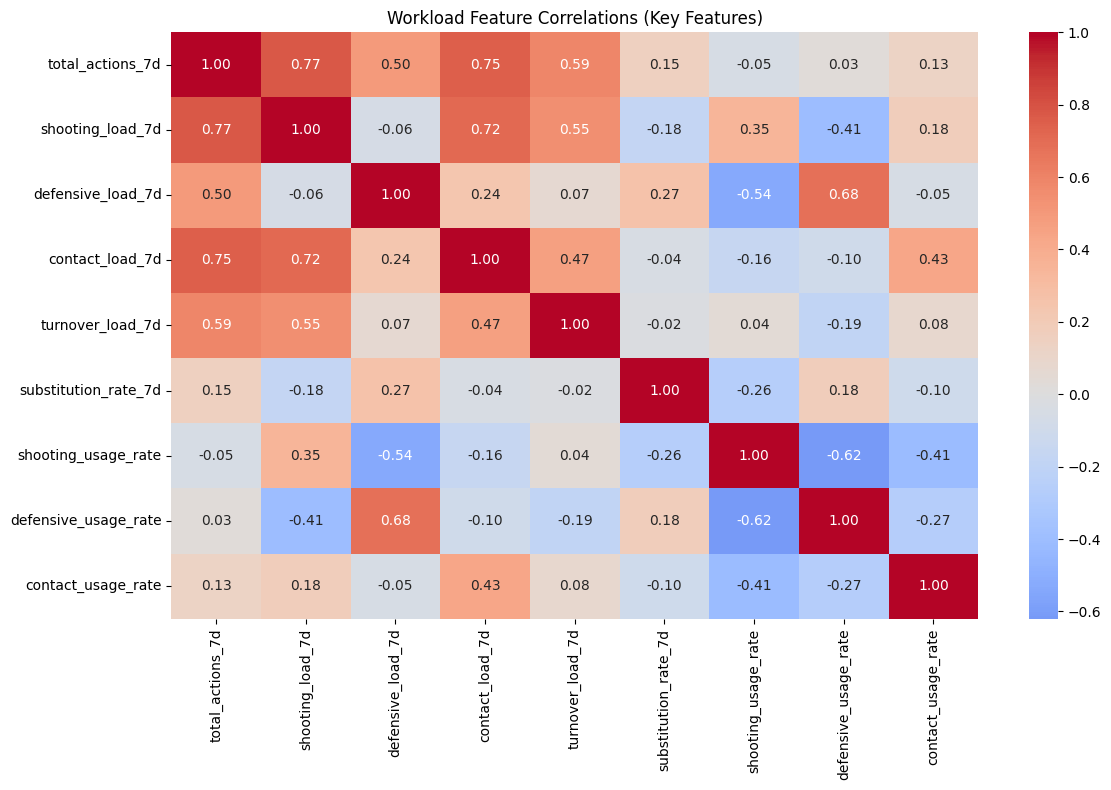

In [25]:
# Analyzes feature correlations and multicollinearity
print("Feature Correlation Analysis")

# Combines all of the workload features
all_workload_features = []
if hasattr(engineer, 'workload_features'):
    all_workload_features.extend(engineer.workload_features)
if hasattr(engineer, 'usage_features'):
    all_workload_features.extend(engineer.usage_features)
if hasattr(engineer, 'comparison_features'):
    all_workload_features.extend(engineer.comparison_features)

print(f"Analyzing correlations of {len(all_workload_features)} features...")

# Correlation matrix
feature_data = engineer.player_data[all_workload_features].corr()

# Finds high correlations (for potential multicollinearity)
print(f"\nHigh Correlations (>0.8):")
high_corr_pairs = []
for i in range(len(feature_data.columns)):
    for j in range(i+1, len(feature_data.columns)):
        corr_val = abs(feature_data.iloc[i,j])
        if corr_val > 0.8:
            high_corr_pairs.append({
                'feature1': feature_data.columns[i],
                'feature2': feature_data.columns[j], 
                'correlation': corr_val
            })

if high_corr_pairs:
    for pair in sorted(high_corr_pairs, key=lambda x: x['correlation'], reverse=True):
        print(f"- {pair['feature1']} vs {pair['feature2']}: {pair['correlation']:.3f}")
else:
    print("No high correlations found")

# Correlation heatmap for key features
plt.figure(figsize=(12, 8))
key_features = [f for f in all_workload_features if '7d' in f or 'usage' in f][:15]
sns.heatmap(engineer.player_data[key_features].corr(), 
            annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Workload Feature Correlations (Key Features)')
plt.tight_layout()
plt.show()

In [26]:
def generate_workload_summary(self):
    """A summary of workload features created"""
    if not hasattr(self, 'workload_features'):
        print("No workload features created yet")
        return
        
    print("Workload Feature Engineering Summary:")
    
    print(f"\nDataset Overview:")
    print(f"- Records: {len(self.player_data):,} player-game records")
    print(f"- Players: {self.player_data['player_id'].nunique()}")
    print(f"- Date range: {self.player_data['game_date'].min().date()} to {self.player_data['game_date'].max().date()}")
    
    print(f"\nFeatures Created:")
    if hasattr(self, 'workload_features'):
        print(f"- Rolling workload features: {len(self.workload_features)}")
    if hasattr(self, 'usage_features'):
        print(f"- Usage rate features: {len(self.usage_features)}")
    if hasattr(self, 'comparison_features'):
        print(f"- Workload comparison features: {len(self.comparison_features)}")
    
    total_features = 0
    if hasattr(self, 'workload_features'):
        total_features += len(self.workload_features)
    if hasattr(self, 'usage_features'):
        total_features += len(self.usage_features)
    if hasattr(self, 'comparison_features'):
        total_features += len(self.comparison_features)
    
    print(f"\nTotal Workload Features: {total_features}")
    
    # Sample feature values
    print(f"\nSample Features (7 day averages):")
    sample_cols = ['player_name', 'game_date', 'total_actions_7d', 'shooting_load_7d', 'defensive_load_7d']
    sample_data = self.player_data[sample_cols].head(5)
    display(sample_data)
    
    # Feature statistics
    print(f"\nFeature Statistics:")
    if hasattr(self, 'workload_features'):
        for feature in self.workload_features[:6]:  # Show first 6
            mean_val = self.player_data[feature].mean()
            std_val = self.player_data[feature].std()
            print(f"- {feature}: μ={mean_val:.2f}, σ={std_val:.2f}")

# Monkey patching method to class
NBAFeatureEngineer.generate_workload_summary = generate_workload_summary
engineer.generate_workload_summary()

Workload Feature Engineering Summary:

Dataset Overview:
- Records: 10,151 player-game records
- Players: 20
- Date range: 2015-01-01 to 2023-04-09

Features Created:
- Rolling workload features: 18
- Usage rate features: 6
- Workload comparison features: 4

Total Workload Features: 28

Sample Features (7 day averages):


,player_name,game_date,total_actions_7d,shooting_load_7d,defensive_load_7d
0,Karl-Anthony Towns,2015-10-30,47.0,26.0,14.0
1,Karl-Anthony Towns,2015-11-02,38.5,35.0,19.0
2,Karl-Anthony Towns,2015-11-05,34.0,48.0,23.0
3,Karl-Anthony Towns,2015-11-07,35.5,67.0,36.0
4,Karl-Anthony Towns,2015-11-09,35.2,82.0,48.0



Feature Statistics:
- total_actions_7d: μ=39.15, σ=7.61
- shooting_load_7d: μ=158.31, σ=43.04
- defensive_load_7d: μ=57.66, σ=24.39
- contact_load_7d: μ=60.91, σ=20.59
- turnover_load_7d: μ=19.54, σ=7.82
- substitution_rate_7d: μ=2.39, σ=1.03


In [29]:
def create_performance_decline_features(self):
    """
    Creates performance decline indicators based on current vs historical patterns
    Enhanced version of existing logic with additional fatigue indicators
    """
    if self.player_data is None:
        raise ValueError("Player data needs to be loaded before this")
    
    df = self.player_data.sort_values(['player_id', 'game_date']).copy()
    
    print("Creating performance decline features...")
    
    # Enhanced Performance Drop Indicators
    print("- Computing performance drop indicators...")
    
    # 7 day vs 30 day performance comparison
    df['performance_drop_7vs30'] = (
        df['total_actions_7d'] / df['total_actions_30d'].replace(0, np.nan)
    )
    
    # Current game vs rolling averages
    df['current_vs_7day_avg'] = (
        df['total_actions'] / df['total_actions_7d'].replace(0, np.nan)
    )
    
    df['current_vs_14day_avg'] = (
        df['total_actions'] / df.groupby('player_id')['total_actions'].transform(
            lambda x: x.rolling(window=14, min_periods=1).mean()
        ).replace(0, np.nan)
    )
    
    # Shooting efficiency decline
    df['shooting_eff_7d'] = df.groupby('player_id')['shooting_efficiency'].transform(
        lambda x: x.rolling(window=7, min_periods=1).mean()
    )
    
    df['shooting_eff_decline'] = (
        df['shooting_efficiency'] - df['shooting_eff_7d']
    )
    
    # Consecutive low performance games
    print("- Computing consecutive performance patterns...")
    
    # Defines low performance (below 70% of personal average)
    df['personal_avg_actions'] = df.groupby('player_id')['total_actions'].transform('mean')
    df['is_low_performance'] = df['total_actions'] < (df['personal_avg_actions'] * 0.7)
    
    # Counts consecutive low games
    df['consecutive_low_games'] = 0
    for player_id in df['player_id'].unique():
        player_mask = df['player_id'] == player_id
        player_df = df[player_mask].copy()
        
        # Calculates consecutive low games
        consecutive = 0
        consecutive_counts = []
        
        for is_low in player_df['is_low_performance']:
            if is_low:
                consecutive += 1
            else:
                consecutive = 0
            consecutive_counts.append(consecutive)
        
        df.loc[player_mask, 'consecutive_low_games'] = consecutive_counts
    
    # Performance trend indicators
    print("- Computing performance trends...")
    
    # 7 day trend in total actions
    df['actions_trend_7d'] = df.groupby('player_id')['total_actions'].transform(
        lambda x: x.rolling(window=7, min_periods=3).apply(
            lambda y: np.polyfit(range(len(y)), y, 1)[0] if len(y) >= 3 else 0
        )
    )
    
    # Efficiency trend
    df['efficiency_trend_7d'] = df.groupby('player_id')['shooting_efficiency'].transform(
        lambda x: x.rolling(window=7, min_periods=3).apply(
            lambda y: np.polyfit(range(len(y)), y.fillna(y.mean()), 1)[0] if len(y) >= 3 else 0
        )
    )
    
    decline_features = [
        'performance_drop_7vs30',
        'current_vs_7day_avg',
        'current_vs_14day_avg',
        'shooting_eff_decline',
        'consecutive_low_games',
        'actions_trend_7d',
        'efficiency_trend_7d'
    ]
    
    self.decline_features = decline_features
    self.player_data = df
    
    print(f"Created {len(decline_features)} performance decline features")
    return df[['player_id', 'player_name', 'game_date'] + decline_features]

# Monkey patching method to class
NBAFeatureEngineer.create_performance_decline_features = create_performance_decline_features

In [30]:
print("Performance Decline Features:")
print("Enhanced logic for detecting performance drops:")
print("- Current vs 7 day and 14 day averages")
print("- 7 day vs 30 day performance comparison")
print("- Shooting efficiency decline tracking")
print("- Consecutive low performance game counter")
print("- Performance trend analysis (7 day slope)")

decline_features = engineer.create_performance_decline_features()

# Display sample results
print(f"\nSample Decline Features:")
sample_player = engineer.player_data['player_name'].iloc[0]
sample_data = decline_features[decline_features['player_name'] == sample_player].head()
display(sample_data[['player_name', 'game_date', 'current_vs_7day_avg', 
                    'shooting_eff_decline', 'consecutive_low_games']])

print(f"\nDecline Feature Statistics:")
for feature in ['performance_drop_7vs30', 'current_vs_7day_avg', 'consecutive_low_games']:
    if feature in engineer.player_data.columns:
        mean_val = engineer.player_data[feature].mean()
        std_val = engineer.player_data[feature].std()
        print(f"- {feature}: μ={mean_val:.3f}, σ={std_val:.3f}")

Performance Decline Features:
Enhanced logic for detecting performance drops:
- Current vs 7 day and 14 day averages
- 7 day vs 30 day performance comparison
- Shooting efficiency decline tracking
- Consecutive low performance game counter
- Performance trend analysis (7 day slope)
Creating performance decline features...
- Computing performance drop indicators...
- Computing consecutive performance patterns...
- Computing performance trends...
Created 7 performance decline features

Sample Decline Features:


,player_name,game_date,current_vs_7day_avg,shooting_eff_decline,consecutive_low_games
0,Karl-Anthony Towns,2015-10-30,1.000000,0.000000,0
1,Karl-Anthony Towns,2015-11-02,0.779221,-0.011696,0
2,Karl-Anthony Towns,2015-11-05,0.735294,-0.224321,1
3,Karl-Anthony Towns,2015-11-07,1.126761,-0.007985,0
4,Karl-Anthony Towns,2015-11-09,0.965909,0.209485,0



Decline Feature Statistics:
- performance_drop_7vs30: μ=1.005, σ=0.093
- current_vs_7day_avg: μ=1.001, σ=0.210
- consecutive_low_games: μ=0.215, σ=1.084


In [35]:
def create_fatigue_indicators(self):
    """
    Creates fatigue indicators based on game frequency and rest patterns
    """
    if self.player_data is None:
        raise ValueError("Player data needs to be loaded before this")
    
    df = self.player_data.sort_values(['player_id', 'game_date']).copy()
    
    print("Creating fatigue indicators...")
    
    # Rest days calculation
    print("- Calculating rest days and game frequency...")
    df['rest_days_since_last'] = df.groupby('player_id')['game_date'].diff().dt.days
    
    # Games in recent periods: Fixed approach
    def rolling_count_days(group, days):
        """Helper function to count games in last N days"""
        result = []
        for i, date in enumerate(group):
            # Counts games within the last N days (including current game)
            cutoff_date = date - pd.Timedelta(days=days-1)
            count = sum(1 for d in group[:i+1] if d >= cutoff_date)
            result.append(count)
        return pd.Series(result, index=group.index)
    
    # Applies the rolling count for each player
    df['games_last_7_days'] = df.groupby('player_id')['game_date'].apply(
        lambda x: rolling_count_days(x, 7)
    ).reset_index(level=0, drop=True)
    
    df['games_last_14_days'] = df.groupby('player_id')['game_date'].apply(
        lambda x: rolling_count_days(x, 14)
    ).reset_index(level=0, drop=True)
    
    # Alternative simpler approach using rolling with integer window
    # This counts the last N games instead of N days, (more stable MAYBE)
    # df['games_last_7_days'] = df.groupby('player_id').rolling(window=7, min_periods=1).size().reset_index(level=0, drop=True)
    
    # Back to back games indicator
    df['is_back_to_back'] = (df['rest_days_since_last'] == 1).astype(int)
    
    # Cumulative games into season
    print("- Computing seasonal fatigue indicators...")
    
    # Calculate days into season for each game
    df['season_start'] = df.groupby(['player_id', 'season_id'])['game_date'].transform('min')
    df['days_into_season'] = (df['game_date'] - df['season_start']).dt.days
    
    # Games played so far this season
    df['games_into_season'] = df.groupby(['player_id', 'season_id']).cumcount() + 1
    
    # Cumulative minutes (using total_actions as proxy with integer window)
    df['cumulative_actions_30d'] = df.groupby('player_id')['total_actions'].transform(
        lambda x: x.rolling(window=30, min_periods=1).sum()
    )
    
    # Fatigue risk score (combination of multiple factors)
    print("- Seasonal progression (games/days into season)")
    print("- Composite fatigue risk score")
    
    # Normalize features for fatigue score
    df['games_7d_norm'] = df['games_last_7_days'] / 7  # Max possible
    df['rest_deficit'] = np.maximum(0, 2 - df['rest_days_since_last'].fillna(2)) / 2
    df['season_fatigue'] = df['games_into_season'] / df.groupby(['player_id', 'season_id'])['games_into_season'].transform('max')
    
    # Composite fatigue score (0-1 scale)
    df['fatigue_score'] = (
        0.3 * df['games_7d_norm'].fillna(0) +
        0.3 * df['rest_deficit'].fillna(0) +
        0.4 * df['season_fatigue'].fillna(0)
    )
    
    fatigue_features = [
        'rest_days_since_last',
        'games_last_7_days',
        'games_last_14_days',
        'is_back_to_back',
        'days_into_season',
        'games_into_season',
        'cumulative_actions_30d',
        'fatigue_score'
    ]
    
    self.fatigue_features = fatigue_features
    self.player_data = df
    
    print(f"Created {len(fatigue_features)} fatigue indicators")
    return df[['player_id', 'player_name', 'game_date'] + fatigue_features]

# Monkey patching the method to classS
NBAFeatureEngineer.create_fatigue_indicators = create_fatigue_indicators

In [36]:
print("Fatigue Indicators:")
print("Game frequency and rest pattern analysis:")
print("- Rest days since last game")
print("- Games in last 7 and 14 days")
print("- Back-to-back game detection")
print("- Seasonal progression (games/days into season)")
print("- Composite fatigue risk score")

fatigue_features = engineer.create_fatigue_indicators()

# Displays sample results
print(f"\nSample Fatigue Features:")
display(fatigue_features.head())

# Analyzes fatigue patterns
print(f"\nFatigue Pattern Analysis:")
print(f"- Average rest days: {engineer.player_data['rest_days_since_last'].mean():.1f}")
print(f"- Back-to-back games: {engineer.player_data['is_back_to_back'].sum():,} ({engineer.player_data['is_back_to_back'].mean()*100:.1f}%)")
print(f"- High fatigue games (score > 0.7): {(engineer.player_data['fatigue_score'] > 0.7).sum():,}")


Fatigue Indicators:
Game frequency and rest pattern analysis:
- Rest days since last game
- Games in last 7 and 14 days
- Back-to-back game detection
- Seasonal progression (games/days into season)
- Composite fatigue risk score
Creating fatigue indicators...
- Calculating rest days and game frequency...
- Computing seasonal fatigue indicators...
- Seasonal progression (games/days into season)
- Composite fatigue risk score
Created 8 fatigue indicators

Sample Fatigue Features:


,player_id,player_name,game_date,rest_days_since_last,games_last_7_days,games_last_14_days,is_back_to_back,days_into_season,games_into_season,cumulative_actions_30d,fatigue_score
0,1626157,Karl-Anthony Towns,2015-10-30,NaN,1,1,0,0,1,47.0,0.048337
1,1626157,Karl-Anthony Towns,2015-11-02,3.0,2,2,0,3,2,77.0,0.096673
2,1626157,Karl-Anthony Towns,2015-11-05,3.0,3,3,0,6,3,102.0,0.145010
3,1626157,Karl-Anthony Towns,2015-11-07,2.0,3,4,0,8,4,142.0,0.150489
4,1626157,Karl-Anthony Towns,2015-11-09,2.0,3,5,0,10,5,176.0,0.155969



Fatigue Pattern Analysis:
- Average rest days: 5.8
- Back-to-back games: 1,528 (15.1%)
- High fatigue games (score > 0.7): 82


In [37]:
def load_player_context_data(self):
    """
    Loads context data from common_player_info table
    """
    if self.conn is None:
        raise ValueError("Database connection required")
    
    print("Loading player context data...")
    
    # Gets player IDs for filtering
    if self.top_players is None:
        self.load_top_players_from_eda()
    
    player_ids = "', '".join(self.top_players['player1_id'].astype(str))
    
    context_query = f"""
    SELECT 
        person_id as player_id,
        display_first_last as player_name,
        birthdate,
        height,
        weight,
        season_exp,
        position,
        draft_year,
        draft_round,
        draft_number,
        from_year,
        to_year
    FROM common_player_info
    WHERE person_id IN ('{player_ids}')
    """
    
    self.context_data = pd.read_sql_query(context_query, self.conn)
    
    print(f"Loaded context data for {len(self.context_data)} players")
    return self.context_data

# Monkey patching method to class
NBAFeatureEngineer.load_player_context_data = load_player_context_data

In [38]:
def create_player_context_features(self):
    """
    Creates player context features from biographical and career data
    """
    if not hasattr(self, 'context_data') or self.context_data is None:
        self.load_player_context_data()
    
    if self.player_data is None:
        raise ValueError("Player data needs to be loaded before this")
    
    # Process context data
    context_df = self.context_data.copy()
    
    # Age calculation (at time of each game)
    print("- Computing age features...")
    context_df['birthdate'] = pd.to_datetime(context_df['birthdate'])
    
    # Height and weight processing
    # Parse height (format: "6-8" -> 80 inches)
    def parse_height(height_str):
        if pd.isna(height_str):
            return np.nan
        try:
            feet, inches = height_str.split('-')
            return int(feet) * 12 + int(inches)
        except:
            return np.nan
    
    context_df['height_inches'] = context_df['height'].apply(parse_height)
    context_df['weight_lbs'] = pd.to_numeric(context_df['weight'], errors='coerce')
    
    # BMI calculation
    context_df['bmi'] = (context_df['weight_lbs'] * 703) / (context_df['height_inches'] ** 2)
    
    # Position risk factors (based on research)
    print("- Creating position risk factors...")
    position_risk = {
        'C': 1.3,    # Centers - highest injury risk
        'PF': 1.2,   # Power forwards
        'SF': 1.0,   # Small forwards - baseline
        'SG': 0.9,   # Shooting guards
        'PG': 0.8,   # Point guards - lowest risk
        'F': 1.1,    # General forward
        'G': 0.85    # General guard
    }
    
    context_df['position_risk_factor'] = context_df['position'].map(position_risk).fillna(1.0)
    
    # Draft position as talent/expectations indicator
    print("- Processing draft information...")
    context_df['draft_year'] = pd.to_numeric(context_df['draft_year'], errors='coerce')
    context_df['draft_round'] = pd.to_numeric(context_df['draft_round'], errors='coerce')
    context_df['draft_number'] = pd.to_numeric(context_df['draft_number'], errors='coerce')
    
    # High draft pick indicator (lottery pick)
    context_df['is_lottery_pick'] = (context_df['draft_number'] <= 14).astype(int)
    
    # Career span
    context_df['career_span'] = context_df['to_year'] - context_df['from_year']
    
    # Merge with player game data
    # Calculate age at each game
    df = self.player_data.merge(
        context_df[['player_id', 'birthdate', 'height_inches', 'weight_lbs', 'bmi',
                   'position_risk_factor', 'season_exp', 'is_lottery_pick', 'career_span']],
        on='player_id',
        how='left'
    )
    
    # Age at game date
    df['age_at_game'] = (df['game_date'] - df['birthdate']).dt.days / 365.25
    
    # Age based risk factors
    df['age_risk_factor'] = np.where(
        df['age_at_game'] < 25, 0.9,  # Young players - slightly lower risk
        np.where(df['age_at_game'] < 30, 1.0,  # Prime years - baseline
                np.where(df['age_at_game'] < 35, 1.2, 1.4))  # Older players - higher risk
    )
    
    context_features = [
        'age_at_game',
        'height_inches',
        'weight_lbs',
        'bmi',
        'position_risk_factor',
        'age_risk_factor',
        'season_exp',
        'is_lottery_pick',
        'career_span'
    ]
    
    self.context_features = context_features
    self.player_data = df
    
    print(f"Created {len(context_features)} context features")
    return df[['player_id', 'player_name', 'game_date'] + context_features]

# Monkey patching method to class
NBAFeatureEngineer.create_player_context_features = create_player_context_features

In [39]:
print("Player Context Features:")
print("Biographical and career context:")
print("- Age at time of each game")
print("- Physical attributes (height, weight, BMI)")
print("- Position based injury risk factors")
print("- Draft position and career span")
print("- Age based risk adjustment")

context_features = engineer.create_player_context_features()

# Displays sample results
print(f"\nSample Context Features:")
display(context_features.head())

print(f"\nContext Feature Summary:")
print(f"- Age range: {engineer.player_data['age_at_game'].min():.1f} to {engineer.player_data['age_at_game'].max():.1f} years")
print(f"- BMI range: {engineer.player_data['bmi'].min():.1f} to {engineer.player_data['bmi'].max():.1f}")
print(f"- Position risk factors: {engineer.player_data['position_risk_factor'].unique()}")
print(f"- Lottery picks: {engineer.player_data['is_lottery_pick'].sum():,} player-games")


Player Context Features:
Biographical and career context:
- Age at time of each game
- Physical attributes (height, weight, BMI)
- Position based injury risk factors
- Draft position and career span
- Age based risk adjustment
Loading player context data...
Loaded context data for 15 players
- Computing age features...
- Creating position risk factors...
- Processing draft information...
Created 9 context features

Sample Context Features:


,player_id,player_name,game_date,age_at_game,height_inches,weight_lbs,bmi,position_risk_factor,age_risk_factor,season_exp,is_lottery_pick,career_span
0,1626157,Karl-Anthony Towns,2015-10-30,NaN,NaN,NaN,NaN,NaN,1.4,NaN,NaN,NaN
1,1626157,Karl-Anthony Towns,2015-11-02,NaN,NaN,NaN,NaN,NaN,1.4,NaN,NaN,NaN
2,1626157,Karl-Anthony Towns,2015-11-05,NaN,NaN,NaN,NaN,NaN,1.4,NaN,NaN,NaN
3,1626157,Karl-Anthony Towns,2015-11-07,NaN,NaN,NaN,NaN,NaN,1.4,NaN,NaN,NaN
4,1626157,Karl-Anthony Towns,2015-11-09,NaN,NaN,NaN,NaN,NaN,1.4,NaN,NaN,NaN



Context Feature Summary:
- Age range: 20.1 to 35.1 years
- BMI range: 23.8 to 29.0
- Position risk factors: [nan  1.]
- Lottery picks: 5,033.0 player-games


In [42]:
def create_seasonal_context_features(self):
    """
    Creates seasonal and game context features
    """
    if self.player_data is None:
        raise ValueError("Player data needs to be loaded before this")
    
    df = self.player_data.sort_values(['player_id', 'game_date']).copy()

    # Back to back detection (enhanced)
    df['rest_days'] = df.groupby('player_id')['game_date'].diff().dt.days
    df['is_back_to_back'] = (df['rest_days'] == 1).astype(int)
    df['is_zero_rest'] = (df['rest_days'] == 0).astype(int)  # Same day (rare)
    df['is_short_rest'] = (df['rest_days'] <= 2).astype(int)  # 2 days or less
    
    # Dense scheduling: 4+ games in 6 days (Fixed approach)
    def rolling_count_6_days(group):
        """Count games in last 6 days for each game"""
        result = []
        for i, date in enumerate(group):
            # Count games within the last 6 days (including current game)
            cutoff_date = date - pd.Timedelta(days=5)  # 6 days total including current
            count = sum(1 for d in group[:i+1] if d >= cutoff_date)
            result.append(count)
        return pd.Series(result, index=group.index)
    
    df['games_last_6_days'] = df.groupby('player_id')['game_date'].apply(
        rolling_count_6_days
    ).reset_index(level=0, drop=True)
    
    df['is_dense_schedule'] = (df['games_last_6_days'] >= 4).astype(int)
    
    # Season progression features
    print("- Computing season progression...")
    # Early, mid, late season indicators
    df['season_game_number'] = df.groupby(['player_id', 'season_id']).cumcount() + 1
    df['total_season_games'] = df.groupby(['player_id', 'season_id'])['season_game_number'].transform('max')
    df['season_progress'] = df['season_game_number'] / df['total_season_games']
    
    # Season phase indicators
    df['is_early_season'] = (df['season_progress'] <= 0.25).astype(int)  # First quarter
    df['is_mid_season'] = ((df['season_progress'] > 0.25) & (df['season_progress'] <= 0.75)).astype(int)
    df['is_late_season'] = (df['season_progress'] > 0.75).astype(int)  # Final quarter
    
    # Month-based patterns (injury rates vary by month)
    print("- Adding temporal patterns...")
    df['game_month'] = df['game_date'].dt.month
    df['game_day_of_week'] = df['game_date'].dt.dayofweek  # 0=Monday, 6=Sunday
    df['is_weekend_game'] = (df['game_day_of_week'] >= 5).astype(int)
    
    # Holiday/special periods (higher injury risk periods)
    df['is_christmas_period'] = ((df['game_month'] == 12) & (df['game_date'].dt.day >= 20)).astype(int)
    df['is_playoff_push'] = ((df['game_month'].isin([3, 4]))).astype(int)  # March/April
    
    seasonal_features = [
        'is_back_to_back',
        'is_zero_rest', 
        'is_short_rest',
        'games_last_6_days',
        'is_dense_schedule',
        'season_progress',
        'is_early_season',
        'is_mid_season',
        'is_late_season',
        'game_month',
        'is_weekend_game',
        'is_christmas_period',
        'is_playoff_push'
    ]
    
    self.seasonal_features = seasonal_features
    self.player_data = df
    
    print(f"Created {len(seasonal_features)} seasonal context features")
    return df[['player_id', 'player_name', 'game_date'] + seasonal_features]

# Monkey patching method to class
NBAFeatureEngineer.create_seasonal_context_features = create_seasonal_context_features


In [43]:
print("Seasonal Context Features:")
print("Game scheduling and temporal patterns:")
print("- Back to back and short rest detection")
print("- Dense scheduling indicators")
print("- Season progression (early/mid/late)")
print("- Monthly and holiday period effects")
print("- Weekend game indicators")

seasonal_features = engineer.create_seasonal_context_features()

# Display sample results and analysis
print(f"\nSample Seasonal Features:")
display(seasonal_features.head())

print(f"\nScheduling Pattern Analysis:")
print(f"- Back to back games: {engineer.player_data['is_back_to_back'].sum():,} ({engineer.player_data['is_back_to_back'].mean()*100:.1f}%)")
print(f"- Dense schedule games (4+ in 6 days): {engineer.player_data['is_dense_schedule'].sum():,}")
print(f"- Weekend games: {engineer.player_data['is_weekend_game'].sum():,} ({engineer.player_data['is_weekend_game'].mean()*100:.1f}%)")
print(f"- Christmas period games: {engineer.player_data['is_christmas_period'].sum():,}")
print(f"- Playoff push games: {engineer.player_data['is_playoff_push'].sum():,}")

Seasonal Context Features:
Game scheduling and temporal patterns:
- Back to back and short rest detection
- Dense scheduling indicators
- Season progression (early/mid/late)
- Monthly and holiday period effects
- Weekend game indicators
- Computing season progression...
- Adding temporal patterns...
Created 13 seasonal context features

Sample Seasonal Features:


,player_id,player_name,game_date,is_back_to_back,is_zero_rest,is_short_rest,games_last_6_days,is_dense_schedule,season_progress,is_early_season,is_mid_season,is_late_season,game_month,is_weekend_game,is_christmas_period,is_playoff_push
0,1626157,Karl-Anthony Towns,2015-10-30,0,0,0,1,0,0.013699,1,0,0,10,0,0,0
1,1626157,Karl-Anthony Towns,2015-11-02,0,0,0,2,0,0.027397,1,0,0,11,0,0,0
2,1626157,Karl-Anthony Towns,2015-11-05,0,0,0,2,0,0.041096,1,0,0,11,0,0,0
3,1626157,Karl-Anthony Towns,2015-11-07,0,0,1,3,0,0.054795,1,0,0,11,1,0,0
4,1626157,Karl-Anthony Towns,2015-11-09,0,0,1,3,0,0.068493,1,0,0,11,0,0,0



Scheduling Pattern Analysis:
- Back to back games: 1,528 (15.1%)
- Dense schedule games (4+ in 6 days): 1,889
- Weekend games: 2,798 (27.6%)
- Christmas period games: 675
- Playoff push games: 2,572


In [44]:
def generate_feature_summary_report(self):
    """
    Creates summary of all engineered features
    """
    
    # Dataset overview
    print(f"\nDataset Overview:")
    print(f"- Total player-game records: {len(self.player_data):,}")
    print(f"- Unique players: {self.player_data['player_id'].nunique()}")
    print(f"- Date range: {self.player_data['game_date'].min().date()} to {self.player_data['game_date'].max().date()}")
    print(f"- Seasons covered: {self.player_data['season_id'].nunique()}")
    
    # Feature categories
    feature_categories = []
    if hasattr(self, 'workload_features'):
        feature_categories.append(('Rolling Workload', len(self.workload_features)))
    if hasattr(self, 'usage_features'):
        feature_categories.append(('Usage Rates', len(self.usage_features)))
    if hasattr(self, 'comparison_features'):
        feature_categories.append(('Workload Comparison', len(self.comparison_features)))
    if hasattr(self, 'decline_features'):
        feature_categories.append(('Performance Decline', len(self.decline_features)))
    if hasattr(self, 'fatigue_features'):
        feature_categories.append(('Fatigue Indicators', len(self.fatigue_features)))
    if hasattr(self, 'context_features'):
        feature_categories.append(('Player Context', len(self.context_features)))
    if hasattr(self, 'seasonal_features'):
        feature_categories.append(('Seasonal Context', len(self.seasonal_features)))
    
    print(f"\nFeature Categories:")
    total_features = 0
    for category, count in feature_categories:
        print(f"- {category}: {count} features")
        total_features += count
    
    print(f"\nTotal Engineered Features: {total_features}")
    
    # Data quality check
    print(f"\nData Quality Check:")
    missing_data = self.player_data.isnull().sum().sum()
    print(f"- Missing values: {missing_data:,}")
    print(f"- Data completeness: {(1 - missing_data / (len(self.player_data) * len(self.player_data.columns))) * 100:.1f}%")
    
    # Key statistics
    print(f"\nKey Statistics:")
    print(f"- Average actions per game: {self.player_data['total_actions'].mean():.1f}")
    print(f"- Average fatigue score: {self.player_data.get('fatigue_score', pd.Series([0])).mean():.3f}")
    if 'age_at_game' in self.player_data.columns:
        print(f"- Player age range: {self.player_data['age_at_game'].min():.1f} - {self.player_data['age_at_game'].max():.1f} years")
    
    # Sample feature correlation (top features)
    return {
        'total_records': len(self.player_data),
        'total_features': total_features,
        'feature_categories': dict(feature_categories),
        'date_range': (self.player_data['game_date'].min(), self.player_data['game_date'].max())
    }

# Monkey patching method to class
NBAFeatureEngineer.generate_feature_summary_report = generate_feature_summary_report

In [45]:
summary_stats = engineer.generate_feature_summary_report()


Dataset Overview:
- Total player-game records: 10,151
- Unique players: 20
- Date range: 2015-01-01 to 2023-04-09
- Seasons covered: 9

Feature Categories:
- Rolling Workload: 18 features
- Usage Rates: 6 features
- Workload Comparison: 4 features
- Performance Decline: 7 features
- Fatigue Indicators: 8 features
- Player Context: 9 features
- Seasonal Context: 13 features

Total Engineered Features: 65

Data Quality Check:
- Missing values: 22,110
- Data completeness: 97.8%

Key Statistics:
- Average actions per game: 39.2
- Average fatigue score: 0.362
- Player age range: 20.1 - 35.1 years


In [46]:

def debug_player_context_join(self):
    """Debugs the player context data join issue"""
    
    # Checks data types and sample values
    print(f"player_data player_id dtype: {self.player_data['player_id'].dtype}")
    print(f"context_data player_id dtype: {self.context_data['player_id'].dtype}")
    
    print(f"\nSample player_ids in player_data: {self.player_data['player_id'].unique()[:5]}")
    print(f"Sample player_ids in context_data: {self.context_data['player_id'].unique()[:5]}")
    
    # Checks for mismatches
    player_data_ids = set(self.player_data['player_id'].astype(str))
    context_data_ids = set(self.context_data['player_id'].astype(str))
    
    print(f"\nPlayer IDs in player_data but not in context_data:")
    missing_context = player_data_ids - context_data_ids
    print(f"Count: {len(missing_context)}")
    if missing_context:
        print(f"Sample missing: {list(missing_context)[:3]}")
    
    print(f"\nPlayer IDs in context_data but not in player_data:")
    missing_player = context_data_ids - player_data_ids
    print(f"Count: {len(missing_player)}")
    if missing_player:
        print(f"Sample missing: {list(missing_player)[:3]}")
    
    # Checks specific problematic player
    kat_id = self.player_data[self.player_data['player_name'] == 'Karl-Anthony Towns']['player_id'].iloc[0]
    print(f"\nKarl-Anthony Towns ID in player_data: {kat_id}")
    print(f"Is KAT ID in context_data? {kat_id in self.context_data['player_id'].values}")
    
    return missing_context, missing_player

def fix_player_context_data_types(self):
    """Fixes data type mismatches for player context join"""
    
    # Ensures both are same data type (string for consistency)
    self.player_data['player_id'] = self.player_data['player_id'].astype(str)
    self.context_data['player_id'] = self.context_data['player_id'].astype(str)

    # Reruns the context feature creation with fixed types
    self.create_player_context_features()

def remove_redundant_features(self):
    """Removes highly correlated features based on correlation analysis"""
    
    # Features to remove 
    features_to_drop = [
        # Perfect correlation: keep actions_vs_career_avg, drop intensity
        'actions_per_game_intensity',
        
        # High correlation between rolling windows:  keep 7d and 30d, drop 14d
        'total_actions_14d',
        'shooting_load_14d', 
        'defensive_load_14d',
        'contact_load_14d',
        'turnover_load_14d',
        'substitution_rate_14d',
        
        # Keep actions_vs_career_avg over actions_vs_season_avg (longer history)
        'actions_vs_season_avg'
    ]
    
    # Checks which features actually exist before dropping
    existing_features_to_drop = [f for f in features_to_drop if f in self.player_data.columns]
    missing_features = [f for f in features_to_drop if f not in self.player_data.columns]
    
    print(f"Features to drop: {len(existing_features_to_drop)}")
    print(f"Features already missing: {len(missing_features)}")
    
    if existing_features_to_drop:
        print(f"Dropping: {existing_features_to_drop}")
        self.player_data = self.player_data.drop(columns=existing_features_to_drop)
        
        # Updates feature lists
        if hasattr(self, 'workload_features'):
            self.workload_features = [f for f in self.workload_features if f not in features_to_drop]
        if hasattr(self, 'usage_features'):
            self.usage_features = [f for f in self.usage_features if f not in features_to_drop]
        if hasattr(self, 'comparison_features'):
            self.comparison_features = [f for f in self.comparison_features if f not in features_to_drop]
    
    # Updates final feature count
    all_feature_cols = []
    for attr in ['workload_features', 'usage_features', 'comparison_features', 
                 'decline_features', 'fatigue_features', 'context_features', 'seasonal_features']:
        if hasattr(self, attr):
            all_feature_cols.extend(getattr(self, attr))
    
    print(f"Final feature count after cleanup: {len(all_feature_cols)}")
    return len(existing_features_to_drop)

def fix_missing_shooting_efficiency(self):
    """Handles missing shooting efficiency values"""

    missing_count = self.player_data['shooting_efficiency'].isnull().sum()
    print(f"Missing shooting efficiency values: {missing_count}")
    
    if missing_count > 0:
        # Checks why they're missing
        missing_mask = self.player_data['shooting_efficiency'].isnull()
        missing_data = self.player_data[missing_mask][['player_name', 'game_date', 'made_shots', 'missed_shots', 'total_shot_attempts']]
        
        print("Sample missing data:")
        print(missing_data.head())
        
        # Fix: Sets efficiency to 0 for games with no shot attempts
        zero_attempts = self.player_data['total_shot_attempts'] == 0
        self.player_data.loc[zero_attempts, 'shooting_efficiency'] = 0.0
        
        # For any remaining NaNs, use forward fill then backward fill
        self.player_data['shooting_efficiency'] = (
            self.player_data
            .groupby('player_id')['shooting_efficiency']
            .fillna(method='ffill')
            .fillna(method='bfill')
            .fillna(0.0)  # Final fallback
        )
        
        final_missing = self.player_data['shooting_efficiency'].isnull().sum()
        print(f"Missing values after fix: {final_missing}")
    
    return missing_count


def apply_all_fixes(self):
    """
    Applies all fixes before proceeding
    """
    
    # Debug and fix player context data
    print("\nDebugging player context join...")
    try:
        missing_context, missing_player = self.debug_player_context_join()
        
        if missing_context or missing_player:
            print("Attempting to fix data type mismatches...")
            self.fix_player_context_data_types()
        else:
            print("No player context join issues found")
            
    except Exception as e:
        print(f"Error in player context fix: {e}")
        print("Continuing with other fixes...")
    
    # Handles missing shooting efficiency
    print("\nFixing missing shooting efficiency...")
    self.fix_missing_shooting_efficiency()
    
    # Removes redundant features
    print("\nRemoving redundant features...")
    dropped_count = self.remove_redundant_features()
    
    # Final validation
    print("\nFinal validation...")
    total_missing = self.player_data.isnull().sum().sum()
    total_records = len(self.player_data)
    total_features = len([col for col in self.player_data.columns if col not in ['player_id', 'player_name', 'game_date', 'game_id', 'season_id', 'season_type']])
    
    print(f"Final dataset stats:")
    print(f"- Records: {total_records:,}")
    print(f"- Features: {total_features}")
    print(f"- Missing values: {total_missing:,}")
    print(f"- Data completeness: {((total_records * len(self.player_data.columns) - total_missing) / (total_records * len(self.player_data.columns)) * 100):.1f}%")
    
# Monkey patching methods to class
NBAFeatureEngineer.debug_player_context_join = debug_player_context_join
NBAFeatureEngineer.fix_player_context_data_types = fix_player_context_data_types
NBAFeatureEngineer.remove_redundant_features = remove_redundant_features
NBAFeatureEngineer.fix_missing_shooting_efficiency = fix_missing_shooting_efficiency
NBAFeatureEngineer.apply_all_fixes = apply_all_fixes


In [47]:
engineer.apply_all_fixes()


print("\nVerification:")
print(f"Context features working: {engineer.player_data['age_at_game'].notna().sum()} non-null age values")
print(f"Shooting efficiency fixed: {engineer.player_data['shooting_efficiency'].notna().sum()} non-null values") 
print(f"Feature count: {len([col for col in engineer.player_data.columns if col.endswith(('_7d', '_30d', '_rate', '_avg', '_score', '_factor'))])}")



Debugging player context join...
player_data player_id dtype: object
context_data player_id dtype: object

Sample player_ids in player_data: ['1626157' '201142' '201566' '201935' '201939']
Sample player_ids in context_data: ['203507' '203078' '202710' '201939' '203076']

Player IDs in player_data but not in context_data:
Count: 5
Sample missing: ['203468', '2544', '203954']

Player IDs in context_data but not in player_data:
Count: 0

Karl-Anthony Towns ID in player_data: 1626157
Is KAT ID in context_data? False
Attempting to fix data type mismatches...
- Computing age features...
- Creating position risk factors...
- Processing draft information...
Error in player context fix: 'birthdate'
Continuing with other fixes...

Fixing missing shooting efficiency...
Missing shooting efficiency values: 15
Sample missing data:
         player_name  game_date  made_shots  missed_shots  total_shot_attempts
4414    Jimmy Butler 2021-12-23           0             0                    0
4928   Antho